In [2]:
import numpy as np

data = np.loadtxt('data.txt')

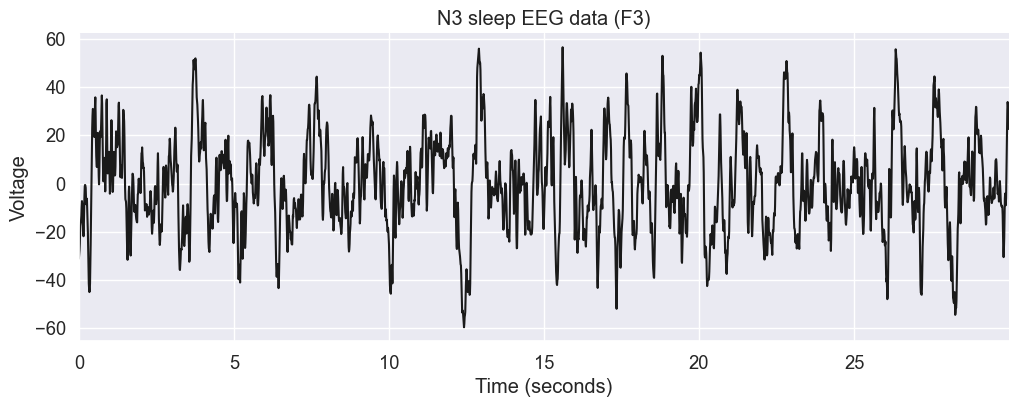

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.2)

#Getting sampling frequency and the time vector
sf = 100. 
time = np.arange(data.size) / sf

# Plot the signal
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(time, data, lw=1.5, color='k')
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage')
plt.xlim([time.min(), time.max()])
plt.title('N3 sleep EEG data (F3)')
sns.despine()
plt.show()

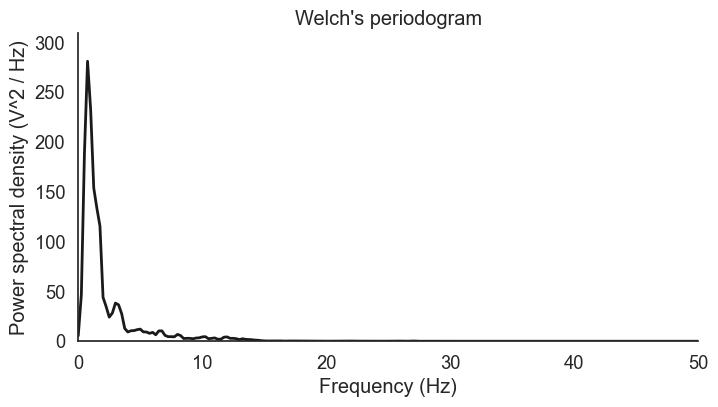

In [4]:
from scipy import signal

#Defining the window length
win = sf * 4 #We do 4 here because the formula for how long the window should be is 2/lowest_freq or 2/0.5=4
freqs, psd = signal.welch(data, sf, nperseg=win) #Welch uses a special technique of applying FFT using window size

#Plotting the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()

The `freqs` vector contains the x-axis, frequency bins, and the `psd` vector contains the y-axis, power spectral density.

The unit is micro-Volts-squared per Hz

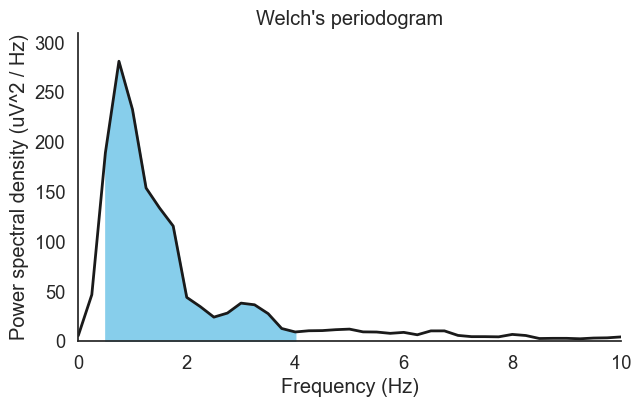

In [5]:
#Defining the delta band limits
low, high = 0.5, 4

#Finding intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

#Plotting the spectral density
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

Now we will use simpson's rule to approxiate the area under the curve which is our bandpower. For us we are now trying to find the area of the blue graph above which will be our bandpower for the delta frequency.

In [9]:
from scipy.integrate import simpson

#Frequnency resolution
freq_res = freqs[1] - freqs[0] # = 1/4 = 0.25

# Compute the absolute bandpower by approximating the AUC
delta_power = simpson(psd[idx_delta], dx=freq_res)
print('Absolute delta power: %.3f uV^2' % delta_power)


Absolute delta power: 321.064 uV^2


In [10]:
#Reporting the relative bandpower as a percentage of total band power
total_power = simpson(psd, dx=freq_res)
delta_rel_power = delta_power / total_power
print('Relative delta power: %.3f' % delta_rel_power)

Relative delta power: 0.787


In [2]:
import numpy as np
def find_baevsky_index(wd):
    """
    Docstring for find_baevsky_index
        
    Args:
        wd -- Working dictionary from heart py with the RR data necessary to find Baevsky stress
    Returns:
        float -- Baevsky index score
    """
    #Extracting and cleaning the data
    rr_list = wd['RR_list']
    rrs = np.array(rr_list)
    rrs = rrs[rrs > 0]

        #If not enough data
    if len(rrs) < 10:
        return 0.0 
        
    # Set up histogram bins
    bin_width = 50
    min_rr = np.min(rrs)
    max_rr = np.max(rrs)

    #Create bins from min to max with 50ms steps
    bins = np.arange(min_rr, max_rr + bin_width, bin_width)

    #If not enough bins
    if len(bins) < 2:
        return 0.0

    #Calculate histogram
    hist, bin_edges = np.histogram(rrs, bins=bins)

    #Deriving components
    max_bin_index = np.argmax(hist)
    #Mode(Mo): Most frequent RR interval in seconds, dominant heart rhythm
    Mo = (bin_edges[max_bin_index] + bin_edges[max_bin_index+1]) / 2 / 1000.0 #Convert to seconds

    #Amplitude of Mode(AMo): Percent of total beats in the bin
    AMo = (hist[max_bin_index] / len(rrs)) * 100.0

    #Variational Range(MxDMn): Max RR - Min RR in seconds
    MxDMn = (max_rr - min_rr) / 1000.0

    if (MxDMn == 0 or Mo == 0):
        return 0.0

    #Calculate Stress Index(si)
    si = AMo / (2 * Mo * MxDMn)

    return si

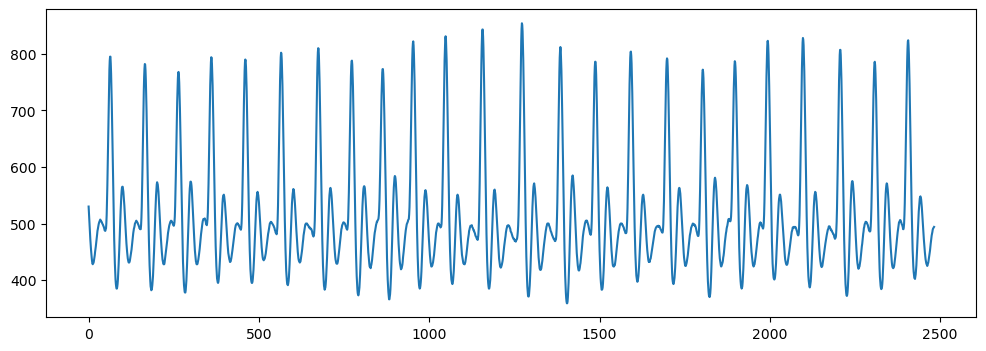

In [11]:
import heartpy as hp
import matplotlib.pyplot as plt

data, timer = hp.load_exampledata(0)

#Visualize
plt.figure(figsize=(12, 4))
plt.plot(data)

In [12]:
# Running the analysis
wd, m = hp.process(data, sample_rate=100.0) #Returns working data and measures

Stress index of user: 54.44504938943767
bpm: 58.898848
ibi: 1018.695652
sdnn: 65.760061
sdsd: 34.866925
rmssd: 64.737231
pnn20: 0.863636
pnn50: 0.409091
hr_mad: 40.000000
sd1: 45.758077
sd2: 82.926832
s: 11921.000816
sd1/sd2: 0.551789
breathingrate: 0.170721


<Figure size 1200x400 with 0 Axes>

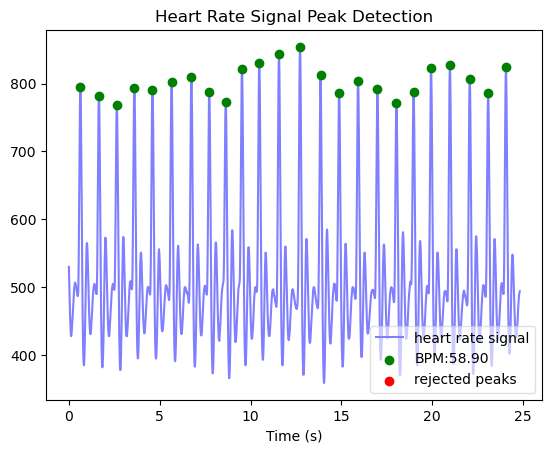

In [13]:
plt.figure(figsize=(12,4))
stress = find_baevsky_index(wd)

print(f'Stress index of user: {stress}')

hp.plotter(wd, m)

#Displaying the measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))


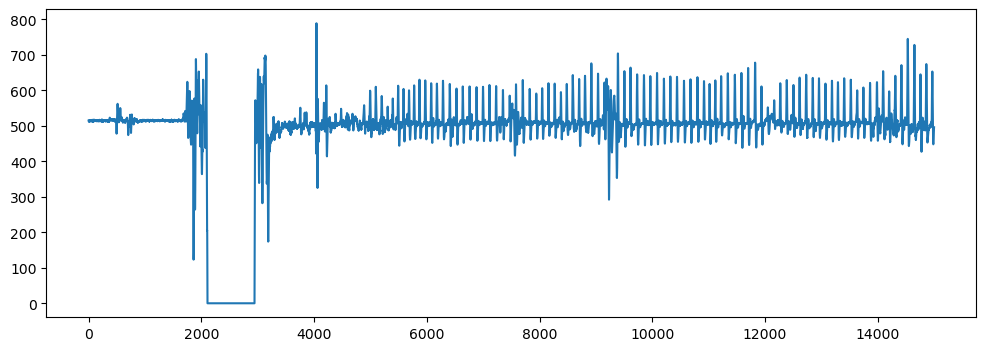

In [14]:
#Exploring the second data set
data, timer = hp.load_exampledata(1)
plt.figure(figsize=(12,4))
plt.plot(data)
plt.show()

Stress index of user: 1.381508309655856
bpm: 62.376304
ibi: 961.903744
sdnn: 64.613519
sdsd: 29.871930
rmssd: 57.069746
pnn20: 0.797297
pnn50: 0.486486
hr_mad: 47.010333
sd1: 40.344402
sd2: 81.621935
s: 10345.227446
sd1/sd2: 0.494284
breathingrate: 0.266667


<Figure size 1200x400 with 0 Axes>

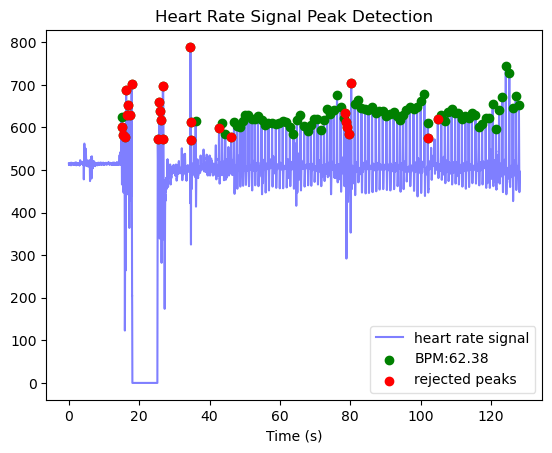

In [15]:
#This is a more realistic signal you might see with a few issues
sample_rate = hp.get_samplerate_mstimer(timer) #Getting the sample rate

wd, m = hp.process(data, sample_rate)

stress = find_baevsky_index(wd)

print(f'Stress index of user: {stress}')

plt.figure(figsize=(12, 4))
hp.plotter(wd, m)

for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))

In [16]:
#Looking at another example
data, timer = hp.load_exampledata(2)

print(timer[0])

2016-11-24 13:58:58.081000


In [17]:
#When computing the sample rate we need to give get_samplerate_datetime the format of the string
#By default it expects HH:MM:SS.ms
sample_rate = hp.get_samplerate_datetime(timer, timeformat='%Y-%m-%d %H:%M:%S.%f')

print(f'Sample data rate is {sample_rate} Hz')

Sample data rate is 100.41971086584796 Hz



Finished in 0.308084 sec
Stress index of user: 13.289132278238696
bpm: 97.325149
ibi: 616.490194
sdnn: 57.916589
sdsd: 30.173744
rmssd: 38.181375
pnn20: 0.320281
pnn50: 0.086345
hr_mad: 29.874613
sd1: 26.997110
sd2: 75.178572
s: 6376.189507
sd1/sd2: 0.359106
breathingrate: 0.141844


<Figure size 1200x400 with 0 Axes>

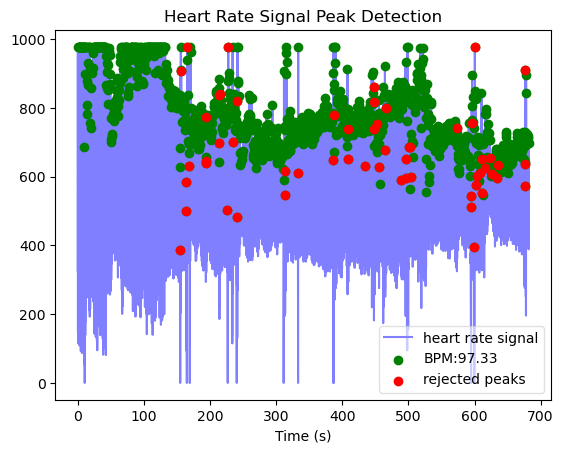

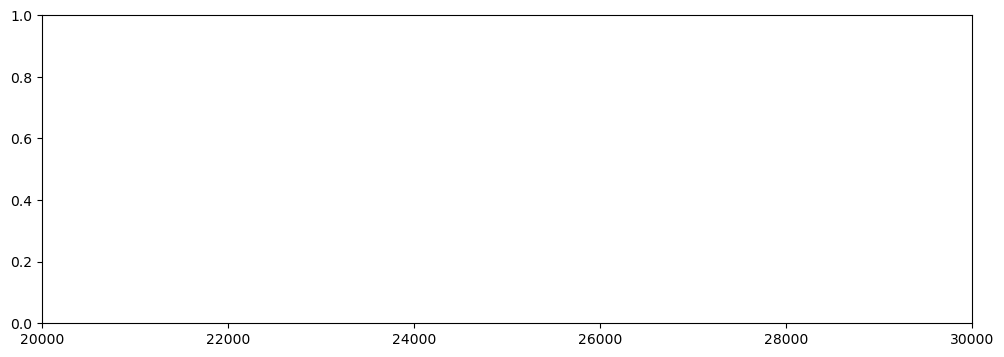

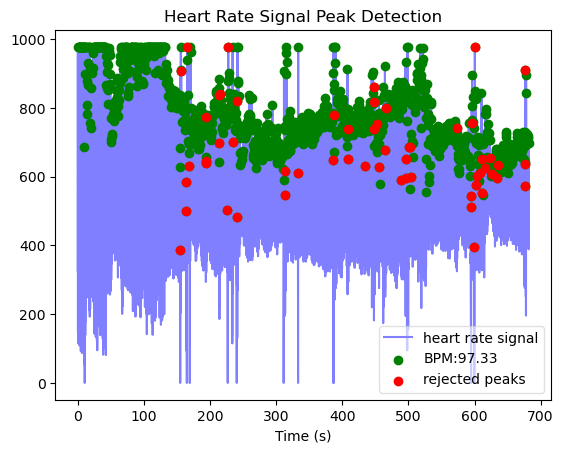

In [18]:
#Plotting the analysis
wd, m = hp.process(data, sample_rate, report_time = True)

stress = find_baevsky_index(wd)

print(f'Stress index of user: {stress}')

#plot
plt.figure(figsize=(12,4))
hp.plotter(wd, m)

#let's zoom in on a bit
plt.figure(figsize=(12,4))
plt.xlim(20000, 30000)
hp.plotter(wd, m)

#display measures computed
for measure in m.keys():
    print('%s: %f' %(measure, m[measure]))
